In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Preprocessed Data

In [2]:
data = pickle.load( open( "datasets/data_ttbar_MG.pkl", "rb" ) )
X_train, y_train, X_val, y_val, X_test, y_test = data

### Define Model

In [3]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 8
        self.num_jet_feats = 4
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        # Track Encoder Stack
        self.trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)
        
        # All Track Encoder Stack
        self.all_trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Cross Encoder Stack
        self.cross_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Jet Encoder Stack
        self.jet_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        jet_trk_embedding, trk_weights = self.trk_encoder1(jet_trk_init, jet_trk_init, jet_trk_init)
        jet_trk_embedding, trk_weights = self.trk_encoder2(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        jet_trk_embedding, trk_weights = self.trk_encoder3(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))
        
        # All Track Attention
        all_trk_embedding, all_trk_weights = self.all_trk_encoder1(trk_init, trk_init, trk_init)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder2(all_trk_embedding, all_trk_embedding, all_trk_embedding)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder3(all_trk_embedding, all_trk_embedding, all_trk_embedding)

        # Cross Attention
        jet_embedding, cross_weights = self.cross_encoder1(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder2(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder3(jet_embedding, all_trk_embedding, all_trk_embedding)
        
        # Update embeddings of jets in the contex of entire event
        jet_embedding, jet_weights = self.jet_encoder1(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder2(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder3(jet_embedding, jet_embedding, jet_embedding)
        
        # Get output
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights, cross_weights

In [4]:
# Get Instance of the model
model = Model()
print(model)
print()

# Pass some data to the model and print outputs
Event_no = 0
Jets    = 0
Trk_Jet = 1
Trks     = 2
output, jet_weights, trk_weights, cross_weights = model(X_train[Event_no][Jets],X_train[Event_no][Trk_Jet],X_train[Event_no][Trks])
print(output.shape)
print(jet_weights.shape)
print(trk_weights.shape)
print(cross_weights.shape)

# Evaluate the loss
loss_fn = nn.MSELoss()
print(loss_fn(output,y_train[Event_no]))

Model(
  (jet_initializer): Linear(in_features=4, out_features=256, bias=True)
  (jet_trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_encoder1): Encoder(
    (pre_norm_Q): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_K): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_V): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (post_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (out): Linear(in_features=256, out_features=256, bias=True)
  )
  (trk_encoder2): Encoder(
    (pre_norm_Q): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_K): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_V): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (atte

### Define Training Loop

In [5]:
def train(model, optimizer, X_train, y_train, X_val, y_val, epochs=40):
    
    combined_history = []
    
    num_train = len(X_train)
    num_val = len(X_val)
    
    step_size=25
    gamma=0.1
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            optimizer.zero_grad()
            
            output, jet_weights, trk_weights, cross_weights = model(X_train[i][0].to(device), X_train[i][1].to(device), X_train[i][2].to(device))
            
            loss=loss_fn(output, y_train[i].to(device))
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            output, jet_weights, trk_weights, cross_weights = model(X_val[i][0].to(device), X_val[i][1].to(device), X_val[i][2].to(device))
            loss=loss_fn(output, y_val[i].to(device))
            
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            
            
        scheduler.step()
            
        cumulative_loss_val = cumulative_loss_val / num_val
        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))
 
        if (e+1)%step_size==0:
            print("\tReducing Step Size by ", gamma)
            
    return np.array(combined_history)

In [6]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

GPU Available:  True
cuda:0



### Train Model

Epoch: 0 	Train Loss: 0.034282 	Val Loss: 0.031892
Epoch: 1 	Train Loss: 0.030701 	Val Loss: 0.030419
Epoch: 2 	Train Loss: 0.029745 	Val Loss: 0.02991
Epoch: 3 	Train Loss: 0.029013 	Val Loss: 0.029141
Epoch: 4 	Train Loss: 0.028667 	Val Loss: 0.028783
Epoch: 5 	Train Loss: 0.028391 	Val Loss: 0.028919
Epoch: 6 	Train Loss: 0.028203 	Val Loss: 0.028993
Epoch: 7 	Train Loss: 0.028018 	Val Loss: 0.029035
Epoch: 8 	Train Loss: 0.025659 	Val Loss: 0.02145
Epoch: 9 	Train Loss: 0.017968 	Val Loss: 0.019005
Epoch: 10 	Train Loss: 0.015518 	Val Loss: 0.016614
Epoch: 11 	Train Loss: 0.014295 	Val Loss: 0.014488
Epoch: 12 	Train Loss: 0.013554 	Val Loss: 0.013061
Epoch: 13 	Train Loss: 0.012846 	Val Loss: 0.015243
Epoch: 14 	Train Loss: 0.012607 	Val Loss: 0.01478
Epoch: 15 	Train Loss: 0.012232 	Val Loss: 0.011948
Epoch: 16 	Train Loss: 0.011878 	Val Loss: 0.012836
Epoch: 17 	Train Loss: 0.011506 	Val Loss: 0.011204
Epoch: 18 	Train Loss: 0.011093 	Val Loss: 0.011272
Epoch: 19 	Train Loss: 0.

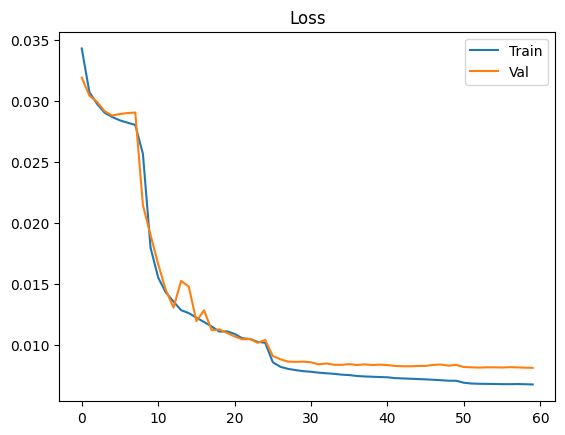

In [7]:
model = Model()
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001)

loss_fn = nn.MSELoss()

combined_history = train(model, optimizer, X_train, y_train, X_val, y_val,epochs=60)

plt.plot(combined_history[:,0], label="Train")
plt.plot(combined_history[:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.show()

### Evaluate Model

Train Loss:	 0.006760951672048707
Val Loss:	 0.008124126726179383
Test Loss:	 0.00816621029691305

Test MAE:	 0.049577397046484534
Test RMSE:	 0.08830429755693901


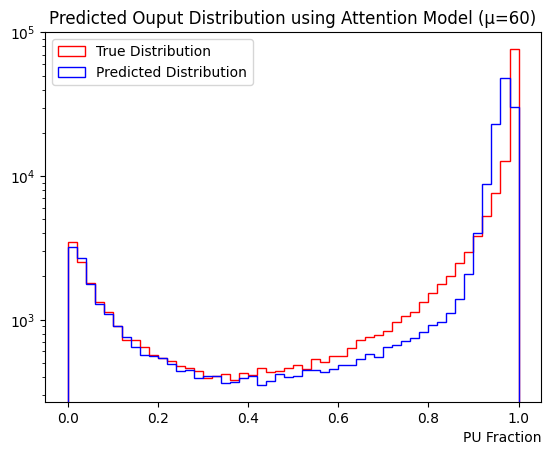

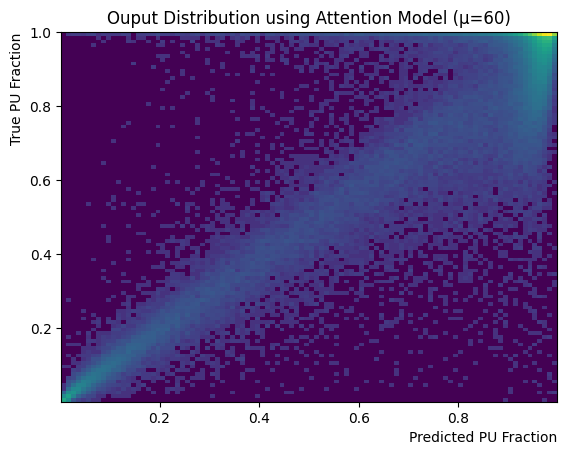

In [8]:
model.eval()
cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []
loss_fn = nn.MSELoss()

num_test = len(X_test)
for i in range(num_test):
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    loss=loss_fn(output, y_test[i].to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
        
    for j in range(output.shape[0]): 
        predicted_labels.append(float(output[j][0].detach().cpu().numpy()))
        true_labels.append(float(y_test[i][j][0].detach().numpy()))
    
cumulative_loss_test = cumulative_loss_test / num_test
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Test MAE:\t", mean_absolute_error(true_labels, predicted_labels))
print("Test RMSE:\t", root_mean_squared_error(true_labels, predicted_labels))

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

plt.title("Ouput Distribution using Attention Model (\u03BC=60)")
plt.hist2d(predicted_labels,true_labels, bins=100,norm=mcolors.PowerNorm(0.2))
plt.xlabel('Predicted PU Fraction',loc='right')
plt.ylabel('True PU Fraction',loc='top')
plt.show()

/tmp/ipykernel_3214702/1057652807.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  bkg_rej = [1/x for x in bkg_eff]
/tmp/ipykernel_3214702/1057652807.py:55: RuntimeWarning: invalid value encountered in divide
  ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x1),np.flip(y1))


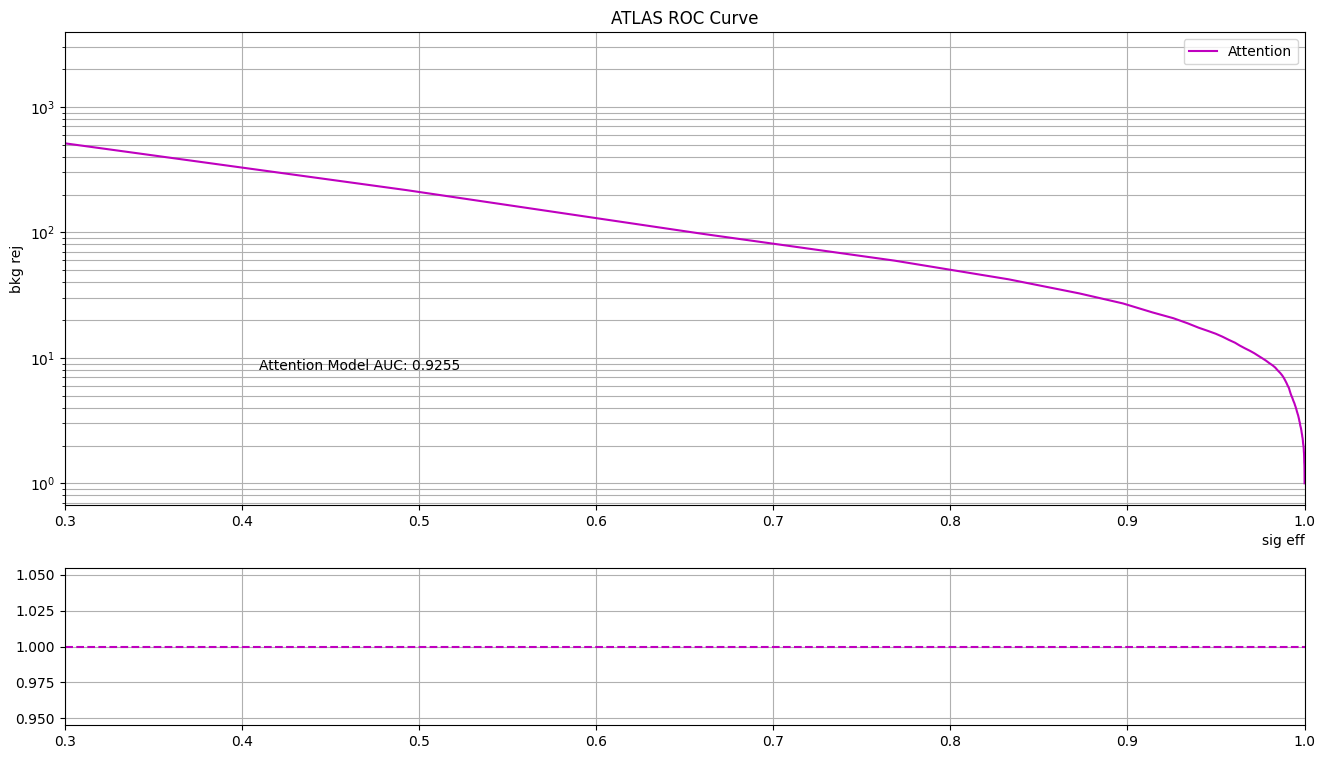

PUFNN	 Binary Accuracy:  0.9651690149362037 	F1 Score:  0.9789915625835839



In [9]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.999,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

def roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    fake_rate = []
    
    thresholds = np.linspace(0,0.97,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        fake_rate.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))
        
    return np.array(sig_eff), np.array(fake_rate), thresholds

def get_metrics(y_true, y_pred, threshold):
    y_Pred = np.array(y_pred > threshold).astype(int)
    y_True = np.array(y_true > threshold).astype(int)
    x1,y1, thresholds1 = ATLAS_roc(y_True, y_pred)
    x2,y2, thresholds2 = roc(y_True, y_pred)
    AUC = roc_auc_score(y_True, y_Pred)
    BA = accuracy_score(y_True, y_Pred)
    f1 = f1_score(y_True, y_Pred)
    return x1,y1,x2,y2,thresholds1,thresholds2,AUC,BA,f1

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

x1,y1,x1_v2,y1_v2,th1,th1_v2,AUC1,BA1,f11 = get_metrics(np.array(true_labels), np.array(predicted_labels), 0.7)

ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="Attention",color='m')
AUC1 = "Attention Model AUC: " + str(round(AUC1,4))
ax1.text(0.41,8,AUC1)

x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x1),np.flip(y1))
ax2.plot(x,ratio1,linestyle='--',color='m')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlim(0.3,1)
ax2.set_xlim(0.3,1)
plt.show()

print("PUFNN\t","Binary Accuracy: ", BA1, "\tF1 Score: ", f11)
print("")

In [10]:
raise Exception("Stop! Don't save results.")

Exception: Stop! Don't save results.

In [ ]:
file_names = ["PUFNN_Results.np"]

results1 = np.concatenate((x1_v2[np.newaxis],y1_v2[np.newaxis],th1_v2[np.newaxis]),axis=0)

results = [results1]

for i, file in enumerate(file_names):
    with open(file, 'wb') as f:
        np.save(f, results[i])

In [ ]:
#print(model)
print("Trainable Parameters :", np.sum(p.numel() for p in model.parameters() if p.requires_grad))

In [11]:
torch.save(model,"PUFNN.torch")

In [12]:
model = torch.load("PUFNN.torch")

/tmp/ipykernel_3214702/457395016.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("PUFNN.torch")


### Visualize Attention Scores

In [ ]:
plot_events=5
for i in range(plot_events):
    # Get Model Predictions
    model.eval()
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    num_jets = len(output)
    
    ticks = [x for x in range(num_jets)]
    jet_labels= [round(float(label.detach().cpu().numpy()[0]),2) for label in y_test[i]]   

    fig, (ax1) = plt.subplots(1, 1, figsize=(15,15))
    im0 = ax1.imshow(jet_weights.detach().cpu().numpy())
    ax1.set_xticks(ticks, jet_labels)
    ax1.set_yticks(ticks, jet_labels)
    ax1.set_title("Attention Scores Between Jets and tracks")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')